<a href="https://colab.research.google.com/github/StaniszewskiA/Self-Sweeping-Mines/blob/dev/SelfSweepingMines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dqn

In [2]:
import random
import unittest
#from game import MinesweeperGame
from keras.layers import Dense, Activation, InputLayer
from keras.models import Sequential, load_model
from keras.optimizers import Adam

import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr & self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    
    
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims, )),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)
            ])

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    
    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                input_dims, epsilon_dec=0.999, epsilon_end=0.01,
                mem_size=100000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)] #Tutaj trzeba będzie zmienić na nasze akcje w saperze
        self.actions_possible = [i for i in range(n_actions)]
        #self.action = actions
        #self.n_actions = len(actions)
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.actions_taken = set()

        self.memory = ReplayBuffer(mem_size, input_dims, self.n_actions,
                                    discrete=True)
        try:
            self.load_model()
        except:
            self.q_eval = build_dqn(alpha, self.n_actions, input_dims, 500, 250)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice([i for i in range(self.action) if i not in self.actions_taken])
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        self.actions_taken.add(action)
        return action

    def learn(self):
        #Using Temporal Difference
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)

        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        q_target[batch_index, action_indices] = reward + \
                self.gamma*np.max(q_next, axis=1)*done

        _ = self.q_eval.fit(state, q_target, verbose=0)

        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                        self.epsilon_min else self.epsilon_min

    def refresh_actions(self):
        self.actions_possible = [i for i in range(self.n_actions)]

    def save_model(self):
        self.q_eval.save(self.model_file)
        
    def load_model(self):
        self.q_eval = load_model(self.model_file)

game

In [7]:
import random
from time import sleep
import numpy as np
import unittest


class MinesweeperGame:
    def __init__(self, board_size, num_bombs):
        self.board_size = board_size
        self.num_bombs = num_bombs
        self.board = None
        self.hidden_board = np.full((self.board_size, self.board_size), '-')
        #self.bomb_locations = self._place_bombs() do wyrzucenia
        self.game_won = False
        self.game_over = False
        self.score = 0
        self.reward = 0
        self.revealed_tiles = 0
        self.score_table = {
            "reveal": 10,
            "flag_correct": 2,
            "flag_incorrect": -5,
            "unflag_bomb": -1,
            "unflag_empty": 0,
            "click_revealed": -5,
            "click_flagged": -5,
            "exploded": -2,
            "win": 20,
        }
        self.moves_taken = []


    def _generate_board(self, board_size, row, col):
        self.board = np.zeros((board_size, board_size), dtype=int)
        self._place_bombs(row, col)

        for y in range(self.board_size):
            for x in range(self.board_size):
                if self.board[y][x] != -1:
                    self.board[y][x] = self._get_num_adjacent_bombs(y, x)

        return self.board

    def _place_bombs(self, row, col):
        seed = 42
        random.seed(seed)
        excluded_locations = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                r = row + i
                c = col + j
                if (
                        r < 0
                        or r >= self.board_size
                        or c < 0
                        or c >= self.board_size
                ):
                    continue
                excluded_locations.append(r*self.board_size+c)
        possible_locations = [i for i in range(self.board_size*self.board_size) if i not in excluded_locations]
        bomb_locations = random.sample(possible_locations, self.num_bombs+1)
        bomb_locations = [(i // self.board_size, i % self.board_size) for i in bomb_locations]

        bombs_placed = 0
        for i, j in bomb_locations:
            if i == row and j == col:
                continue
            self.board[i][j] = -1
            bombs_placed+=1
            if bombs_placed == self.num_bombs:
                break
        self.board = self.board.astype(int)  # Cast to int
        return bomb_locations

    def _get_neighbors(self, row, col):
        neighbors = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0:
                    continue
                r = row + i
                c = col + j
                if (
                        r < 0
                        or r >= self.board_size
                        or c < 0
                        or c >= self.board_size
                ):
                    continue
                neighbors.append((r, c))
        return neighbors

    def _get_num_adjacent_bombs(self, row, col):
        num_adjacent_bombs = 0
        for neighbor_row, neighbor_col in self._get_neighbors(row, col):
            if self.board[neighbor_row][neighbor_col] == -1:
                num_adjacent_bombs += 1
        return num_adjacent_bombs

    def _reveal(self, row, col):
        if self.hidden_board[row][col] == '-':
            if self.revealed_tiles == 0:
                self.board = self._generate_board(self.board_size, row, col)
            if self.board[row][col] == -1:
                self.score += self.score_table["exploded"]
                self.reward = self.score_table["exploded"]
                print("Exploded on ",row,col)
                #print(self.board)
                #print(self.hidden_board)
                #print(self.moves_taken)
                self.game_over = True
                self.revealed_tiles += 1
                return self.board[row][col]
            else:
                if self.board[row][col] == 0:
                    # Reveal all the adjacent tiles with DFS algorithm
                    self.score += self.score_table["reveal"]
                    self.reward = self.score_table["reveal"]
                    print("Revealed tile ",row,col)
                    self.revealed_tiles = self._reveal_zeroes(row, col, self.revealed_tiles)
                else:
                    # Reveal the tile
                    self.score += self.score_table["reveal"]
                    self.reward = self.score_table["reveal"]
                    print("Revealed tile ",row,col)
                    self.hidden_board[row][col] = self.board[row][col]
                    self.revealed_tiles += 1
                    
                if self.revealed_tiles == self.board_size ** 2 - self.num_bombs:
                    # All non-bomb tiles have been revealed
                    self.score += self.score_table["win"]
                    self.reward = self.score_table["win"]
                    print("Game won!")
                    self.game_won = True
                    self.game_over = True
                return self.board[row][col]
        elif self.hidden_board[row][col] == 'F':
            self.score += self.score_table["click_flagged"]
            self.reward = self.score_table["click_flagged"]
            print("Clicked (reveal) on flaged tile ",row,col)
            return None
        else:
            self.score += self.score_table["click_revealed"]
            self.reward = self.score_table["click_revealed"]
            print("Clicked (reveal) on already revealed tile ",row,col)
            #print("This tile has already been revealed")
            return None

        
    

    def _reveal_zeroes(self, row, col, revealed_tiles):
        # Revealing 0's with DFS algorithm
        if self.hidden_board[row][col] == '-':
            if self.board[row][col] != 0:
                self.hidden_board[row][col] = self.board[row][col]
                revealed_tiles += 1
            else:
                self.hidden_board[row][col] = '0'
                revealed_tiles += 1
                for r in range(max(0, row - 1), min(row + 2, len(self.board))):
                    for c in range(max(0, col - 1), min(col + 2, len(self.board[0]))):
                        if (r != row or c != col) and self.board[r][c] == 0 and self.hidden_board[r][c] == "-":
                            revealed_tiles = self._reveal_zeroes(r, c, revealed_tiles)
                        elif (r != row or c != col) and self.board[r][c] != -1 and self.hidden_board[r][c] == "-":
                            self.hidden_board[r][c] = self.board[r][c]
                            revealed_tiles += 1
        return revealed_tiles

    def _flag(self, row, col):
        if self.hidden_board[row][col] == '-':
            self.hidden_board[row][col] = 'F'
            # Increase the score if flagged tile was a bomb
            if self.board[row][col] == -1:
                self.score += self.score_table["flag_correct"]
                self.reward = self.score_table["flag_correct"]
                print("Flagged correctly tile ",row,col)
            else:
                self.score += self.score_table["flag_incorrect"]
                self.reward = self.score_table["flag_incorrect"]
                print("Flagged incorrectly tile ",row,col)
            return True

        elif self.hidden_board[row][col] == 'F':
            self.hidden_board[row][col] = '-'
            # Decrease the score if unflagged tile was a bomb
            if self.board[row][col] == -1:
                self.score += self.score_table["unflag_bomb"]
                self.reward = self.score_table["unflag_bomb"]
                print("Unflagged bomb on tile ",row,col)
            else:
                self.score += self.score_table["unflag_empty"]
                self.reward = self.score_table["unflag_empty"]
                print("Unflagged empty tile ",row,col)

            return True

        else:
            #print("This tile has already been revealed and cannot be flagged")
            self.score += self.score_table["click_revealed"]
            self.reward = self.score_table["click_revealed"]
            print("Clicked (flag) on already revealed tile",row,col)
            return False

    def _make_move(self, action):
        row, col, move = action
        self.moves_taken.append(action)
        if move == 'R' or self.revealed_tiles == 0:
            self._reveal(row, col)
        else:
            self._flag(row, col)
        #print(self.hidden_board)
        #sleep(1)
        #return self.hidden_board, self.score, self.game_over


    def _get_state(self):
        if not self.game_over:
            float_board = self._convert(self.hidden_board.flatten())
            #return self.game_over, self.score, self.hidden_board.flatten()
        else:
            float_board = self._convert(self.board.flatten())
            #return self.game_over, self.score, self.board.flatten()
        return self.game_over, self.reward, float_board, self.game_won

    def _reset(self, board_size, num_bombs):
        self.board = None
        self.hidden_board = np.full((self.board_size, self.board_size), '-')
        self.revealed_tiles = 0
        self.game_over = False
        self.score = 0
        self.moves_taken = []
        self.game_won = False
        float_board = self._convert(self.hidden_board.flatten())
        return float_board
    
    def _convert(self, board):
        float_board = np.zeros(81,)
        for i in range(len(board)):
            #print(board)
            try:
                float_board[i] = float(board[i])
            except:
                if board[i] == "-":
                    float_board[i] = -2
                elif board[i] == "F":
                    float_board[i] = -3
                else:
                    continue
            #print("step: ", i)
            #print(float_board)
        return float_board


def main():
    from test_game import TestMinesweeperGame
    # Creating a test suite
    suite = unittest.TestSuite()
    suite.addTest(unittest.makeSuite((TestMinesweeperGame)))

    # Run the test suite
    runner = unittest.TextTestRunner()
    result = runner.run(suite)


if __name__ == "__main__":
    main()

    #print("Done")


'\ndef main():\n    from test_game import TestMinesweeperGame\n    # Creating a test suite\n    suite = unittest.TestSuite()\n    suite.addTest(unittest.makeSuite((TestMinesweeperGame)))\n\n    # Run the test suite\n    runner = unittest.TextTestRunner()\n    result = runner.run(suite)\n\n\nif __name__ == "__main__":\n    main()\n\n    #print("Done")\n'

main

Number of games:  101
Number of experiments:  1
episode 0 score -10.00 average score -10.00
episode 1 score 34.00 average score 12.00
episode 2 score 17.00 average score 13.67
episode 3 score 10.00 average score 12.75
episode 4 score -10.00 average score 8.20
episode 5 score 3.00 average score 7.33
episode 6 score 48.00 average score 13.14
episode 7 score -17.00 average score 9.38
episode 8 score 12.00 average score 9.67
episode 9 score 23.00 average score 11.00
episode 10 score 17.00 average score 11.55


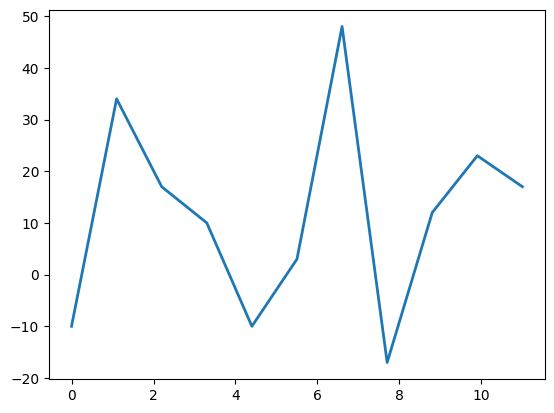

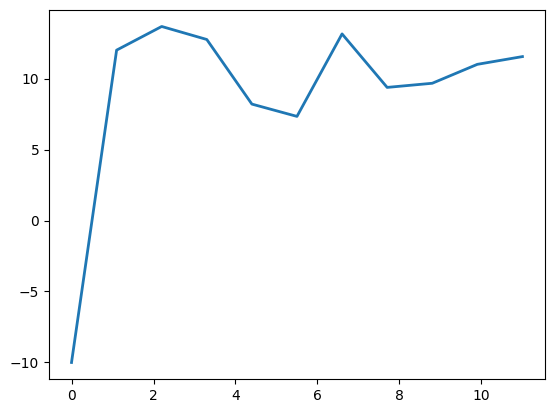

episode 11 score 11.00 average score 11.50
episode 12 score 5.00 average score 11.00
episode 13 score 22.00 average score 11.79
episode 14 score -12.00 average score 10.20
episode 15 score 25.00 average score 11.12
episode 16 score 20.00 average score 11.65
episode 17 score 3.00 average score 11.17
episode 18 score 3.00 average score 10.74
episode 19 score -12.00 average score 9.60
episode 20 score -9.00 average score 8.71


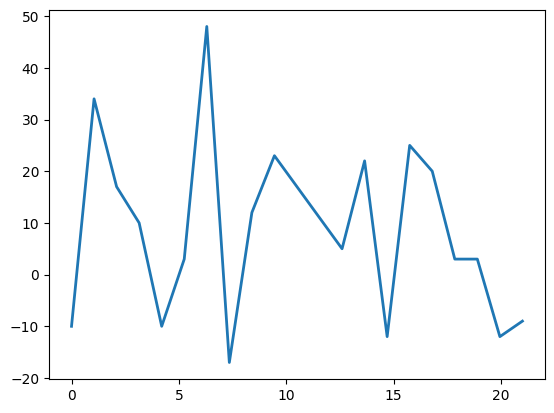

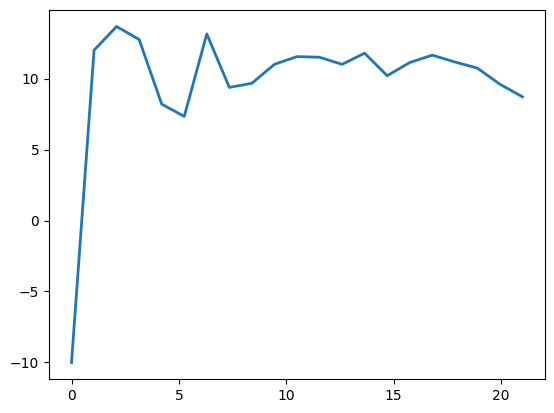

episode 21 score 8.00 average score 8.68
episode 22 score -12.00 average score 7.78
episode 23 score -2.00 average score 7.38
episode 24 score 8.00 average score 7.40


KeyboardInterrupt: ignored

In [10]:
#from dqn import Agent
import numpy as np
#import game
import tensorflow
import matplotlib.pyplot as plt

tensorflow.keras.utils.disable_interactive_logging()

board_size = 9
num_bombs = 20
print_moves = False

def gen_action_list():
    actions = []
    for i in range(board_size):
        for j in range(board_size):
            actions.extend([(i, j, 'R'), (i, j, 'F')])  #Append each tuple separately

    return actions

if __name__ == "__main__":
    

    actions = gen_action_list()
    """
    Input layer - 
    """
    
    env = MinesweeperGame(board_size, num_bombs, print_moves)

    try:
        n_games = int(input("How many games? (default=101)"))
    except:
        n_games = 101

    print("Number of games: ", n_games)

    try:
        n_experiments = int(input("How many games? (default=1)"))
    except:
        n_experiments = 1

    print("Number of experiments: ", n_experiments)


    for i in range(n_experiments):

        # gamma set to 0.0 from 0.99 for testing purposes
        agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=81,
                      n_actions=len(actions), mem_size=100000, batch_size=256, epsilon_end=0.01)
        

        scores = []
        avg_scores = []
        eps_history = []

        '''
        f = open("result.txt","r+")
        eps_before = f.readline()
        if eps_before == "":
            eps_before = 0
        f.close()
        
        print(eps_before)
        '''
        for i in range(n_games):
            taken_actions = []
            done = False
            score = 0
            observation = env._reset(board_size,num_bombs)
            moves_taken = 0
            while not done:
                action = agent.choose_action(observation)
                if moves_taken == 0 and action % 2 == 1:
                    action -= 1
                env._make_move(actions[action])
                if action in taken_actions:
                  done = True
                  break
                taken_actions.append(action)
                moves_taken += 1
                #print("Moves taken: ", moves_taken)
                done, reward, observation_, is_won = env._get_state()
                score += reward + moves_taken
                agent.remember(observation, action, reward, observation_, done)
                observation = observation_
                agent.learn()

            eps_history.append(agent.epsilon)
            scores.append(score)

            avg_score = np.mean(scores[max(0, i-100):(i+1)])
            avg_scores.append(avg_score)

            #print('episode', i+int(eps_before), "score %.2f" % score, 'average score %.2f' % avg_score)
            print('episode', i, "score %.2f" % score,
                    'average score %.2f' % avg_score, 'won:' % is_won)
            
            actions = gen_action_list()

            agent.refresh_actions()
        
            if i % 10 == 0 and i > 0:
                '''f = open("result.txt", "w+")
                f.write(str(i))
                f.close()
                '''
                x = np.linspace(0, i+1, i+1)

                # plot
                fig, ax = plt.subplots()
                fig_avg, ax_avg = plt.subplots()

                ax.plot(x, scores, linewidth=2.0)
                ax_avg.plot(x, avg_scores, linewidth=2.0)

                plt.show()

                agent.save_model()



test_game

In [ ]:
from unittest import TestCase
#from game import MinesweeperGame
import numpy as np

class TestMinesweeperGame(TestCase):

    def setUp(self):
        self.game = MinesweeperGame(9,10)

    def test__generate_board(self):
        #Check if two generated game boards aren't the same
        result1 = self.game.board
        result2 = self.game._generate_board(9,10)

        self.assertFalse(np.array_equal(result1, result2))

    def test__place_bombs(self):
        bomb_locations = self.game._place_bombs()
        num_bombs = len(bomb_locations)

        #Check that the number of bombs placed is correct
        self.assertEqual(num_bombs, 10)

        #Check that all bomb locations are valid
        for row, col in bomb_locations:
            self.assertLess(row, 9)
            self.assertLess(col, 9)
            self.assertEqual(self.game.board[row][col], -1)

    def test__get_neighbors(self):
        #Test the center cell
        neighbors = self.game._get_neighbors(1, 1)
        expected_neighbors = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)]
        self.assertCountEqual(neighbors, expected_neighbors)

    def test__get_num_adjacent_bombs(self):
        #Ensure that the method doesn't count the bomb at given position as adjacent
        self.game.board = np.array([
            [0, 0, 0],
            [0, -1, 0],
            [0, 0, 0]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(1,1)
        self.assertEqual(num_adjacent_bombs, 0)

        # Ensure that the method count only the bombs at adjacent tiles
        self.game.board = np.array([
            [0, 0, -1],
            [-1, -1, -1],
            [-1, -1, -1]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(0, 0)
        self.assertEqual(num_adjacent_bombs, 2)

        # Ensure that the method checks every adjacent tiles
        self.game.board = np.array([
            [-1, -1, -1],
            [-1, 0, -1],
            [-1, -1, -1]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(1,1)
        self.assertEqual(num_adjacent_bombs, 8)


    def test__reveal(self):
        self.game.board = np.array([
            [1, 1, 1],
            [1, -1, 1],
            [1, 1, 1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Revealing a non-bomb tile
        result = self.game._reveal(0, 0)
        self.assertEqual(result, 1)

        #Revealing a bomb tile and checking if revealing it ends the game
        result = self.game._reveal(1, 1)
        self.assertTrue(self.game.game_over)

        #Check the scoring system
        self.game.score = 0

        self.game.board = self.game.board = np.array([
            [0, 1, 1],
            [0, 1, -1],
            [0, 1, 1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        self.game._reveal(0,0)
        self.assertEqual(self.game.score, 1)

        self.game._reveal(1,1)
        self.assertEqual(self.game.score, 0)

        self.game._reveal(0,2)
        self.assertEqual(self.game.score, 1)

        self.game._reveal(1,2)
        self.assertEqual(self.game.score, -9)


    def test__reveal_zeroes(self):
        # Revealing 0s
        self.game.revealed_tiles = 0
        self.game.board = self.game.board = np.array([
            [0, 0, 0],
            [1, 1, 1],
            [0, 1, 1]
        ])
        #print(self.game.board)

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])
        #print(self.game.hidden_board)

        self.game.expected_board = np.array([
            [0, 0, 0],
            [1, 1, 1],
            ['-', '-', '-']
        ])

        result = self.game._reveal(0, 0)
        #self.assertTrue(np.array_equal(self.game.hidden_board, self.game.expected_board))

    def test__flag(self):
        #Test flagging a tile that has not been revealed
        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        result = self.game._flag(0,0)
        self.assertEqual(self.game.hidden_board[0][0], 'F')
        self.assertEqual(result, True)

        #Test unflagging a flagged tile
        result = self.game._flag(0,0)
        self.assertEqual(self.game.hidden_board[0][0], '-')
        self.assertEqual(result, True)

        #Test flagging an already revealed tile
        self.game.hidden_board = np.array([
            [1, '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])
        result = self.game._flag(0,0)
        self.assertEqual(result, False)

        #Test flagging a bomb and scoring system
        self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])
        self.game.hidden_board = np.array([
            ['0', '0', '0'],
            ['0', '1', '1'],
            ['0', '1', '-']
        ])

        #Flagging an already revealed tile
        self.game.score = 0
        self.game._flag(0,0)
        self.assertEqual(self.game.score, -1)

        #Flagging a bomb
        self.game._flag(2,2)
        self.assertEqual(self.game.score, 0)

        #Unflagging a bomb
        self.game._flag(2,2)
        self.assertEqual(self.game.score, -1)


    def test__make_move(self):
        self.game.score = 0
        self.game.board = self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Reveal a zero tile
        action = (0,0,'R')

        self.game._make_move(action)

        self.assertEqual(int(self.game.hidden_board[0][0]), 0)
        self.assertEqual(int(self.game.hidden_board[0][1]), 0)
        self.assertEqual(int(self.game.hidden_board[0][2]), 0)
        self.assertEqual(int(self.game.hidden_board[1][0]), 0)
        self.assertEqual(int(self.game.hidden_board[2][0]), 0)

        #Reveal a non-zero tile
        action = (1,1,'R')

        self.game._make_move(action)
        self.assertEqual(int(self.game.hidden_board[1][1]), 1)

        #Flag a bomb
        action = (2,2,'F')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], 'F')

        #Unflag a bomb
        action = (2, 2,'F')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], '-')

        #Reveal a bomb
        action = (2,2,'R')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], '-')
        self.assertEqual(self.game.game_over, True)


    def test__get_state(self):
        self.game.score = 0
        self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Checking return statement after making no moves
        lost, score, board = self.game._get_state()

        self.game.expected_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        assert not lost
        self.assertEqual(score, 0)
        self.assertTrue(np.array_equal(board, self.game.expected_board))

        #Checking return statement after making a valid move
        action = (1,1,'R')
        self.game._make_move(action)
        lost, score, board = self.game._get_state()

        self.game.expected_board = np.array([
            ['-', '-', '-'],
            ['-', '1', '-'],
            ['-', '-', '-']
        ])

        assert not lost
        self.assertEqual(score, 1)
        self.assertTrue(np.array_equal(board, self.game.expected_board))

        #Checking return statement after losing a game
        action = (2,2,'R')
        self.game._make_move(action)
        lost, score, board = self.game._get_state()

        assert lost
        self.assertEqual(score, -9)
        self.assertTrue(np.array_equal(board, self.game.board))


    def test__reset(self):
        self.game._generate_board(9,10)
        lost, score, board = self.game._get_state()
        #print(lost, score, board)

        action = (0,0,'R')
        self.game._make_move(action)
        
        lost, score, board = self.game._get_state()
        #print(lost, score, board)

        self.game._reset(9,10)
        lost, score, board = self.game._get_state()
        #print(lost, score, board)
        
        assert not lost
        self.assertEqual(score, 0)
        self.assertTrue(np.array_equal(np.full((9, 9), '-'), self.game.hidden_board))






